In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import tensorboard
from mlp_helper import get_dataset, get_dataset_2
import tensorflow as tf
from tensorboard.plugins.mesh import summary_v2 as mesh_summary

In [4]:
tensorboard.__version__, tf.__version__

('2.5.0', '2.5.0')

In [5]:
# from tensorboardX import SummaryWriter

In [6]:
import numpy as np
from lab_helper import plot_boundaries
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot as plt
from PlotCallback import PlotCallback
from datetime import datetime

In [7]:
# import sys; sys.path.insert(0, '..')
# from BinaryModelPlotKeras.TensorboardMPLCallback import PlotCallbackTB

In [8]:
plt.cm

<module 'matplotlib.cm' from '/Users/julian/opt/anaconda3/envs/RL/lib/python3.9/site-packages/matplotlib/cm.py'>

In [9]:
def generate_gaussians_distributions(sep=1, N=500, random_state=42, normalize=True):
    np.random.seed(random_state)
    # Zeros
    X1 = np.random.multivariate_normal(sep*np.array([0.5, 0.5]), [[0.1,-0.085],[-0.085,0.1]], N//2)
    # Ones
    X2 = np.random.multivariate_normal([-0.25, -0.25], [[0.1,0],[0,0.1]], N//2)
    X = np.append(X1, X2, axis=0)
    y = np.append(np.zeros(N//2), np.ones(N//2))
    indexes = np.arange(len(y))
    np.random.shuffle(indexes)
    if normalize:
        X = (X - X.mean(axis=0))/X.std(axis=0)
    else:
        X[:, 0] = X[:, 0]
        X[:, 1] = X[:, 1]
    return X[indexes], y[indexes]

# Generamos un dataset de tamaño limitado

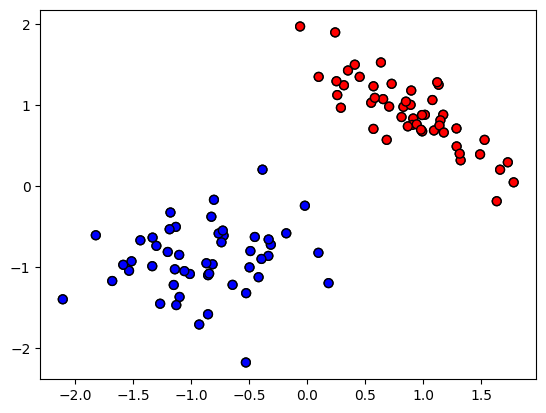

In [87]:
X, y = generate_gaussians_distributions(sep=2,N = 100, random_state=10)
plot_boundaries(X,y)
plt.show()

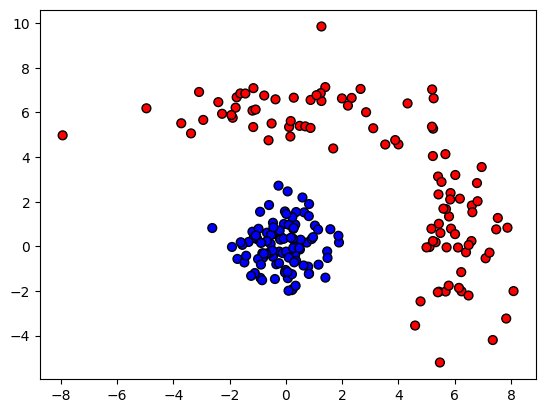

In [38]:
X, y = get_dataset()
plot_boundaries(X,y)
plt.show()

In [39]:
f, ax = plt.subplots(1, 1, figsize=(10,10))
plot_boundaries(X,y, ax=ax)

In [103]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow.keras.backend as K
from sklearn.preprocessing import PolynomialFeatures

# Feature engineering (Polinomio de orden 4)

In [88]:
degree = 10
polyFeat = PolynomialFeatures(degree=degree, interaction_only=False, include_bias=False)

In [89]:
X_poly = polyFeat.fit_transform(X)
X_poly.shape

(100, 65)

In [90]:
X_poly[0]

array([0.81414062, 0.85030035, 0.66282496, 0.69226406, 0.72301069,
       0.53963272, 0.56360029, 0.58863237, 0.61477624, 0.43933692,
       0.4588499 , 0.47922953, 0.50051431, 0.52274446, 0.35768204,
       0.37356834, 0.39016023, 0.40748904, 0.4255875 , 0.4444898 ,
       0.29120348, 0.30413716, 0.31764529, 0.33175338, 0.34648807,
       0.3618772 , 0.37794983, 0.23708058, 0.24761042, 0.25860794,
       0.2700939 , 0.28209002, 0.29461893, 0.30770431, 0.32137087,
       0.19301693, 0.2015897 , 0.21054323, 0.21989442, 0.22966094,
       0.23986124, 0.25051458, 0.26164108, 0.27326177, 0.15714293,
       0.16412237, 0.17141179, 0.17902498, 0.1869763 , 0.19528078,
       0.2039541 , 0.21301264, 0.22247351, 0.23235458, 0.12793644,
       0.13361869, 0.13955331, 0.14575151, 0.152225  , 0.15898602,
       0.16604732, 0.17342224, 0.18112472, 0.1891693 , 0.19757118])

In [91]:
# import pandas as pd

In [92]:
# print(X_poly)

# Definimos modelo

In [104]:
def get_model(lr=1, load_initial_weight=True):
    model = Sequential()
    # Que pasa si no pongo la función de activación??!
    model.add(Dense(1, input_shape=(X_poly.shape[1],), activation='sigmoid', kernel_regularizer=l2(10)))
    # model.save_weights('initial_weights_poly_4.hdf5')
    model.compile(Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
    if load_initial_weight:
        model.load_weights('initial_weights_poly_4.hdf5')
    return model 

In [105]:
lr = 0.1
model = get_model(lr, load_initial_weight=False)
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 1)                 66        
Total params: 66
Trainable params: 66
Non-trainable params: 0
_________________________________________________________________


/Users/julian/opt/anaconda3/envs/RL/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


# Graficamos condición inicial particular (Aleatoria)

/Users/julian/opt/anaconda3/envs/RL/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/julian/opt/anaconda3/envs/RL/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


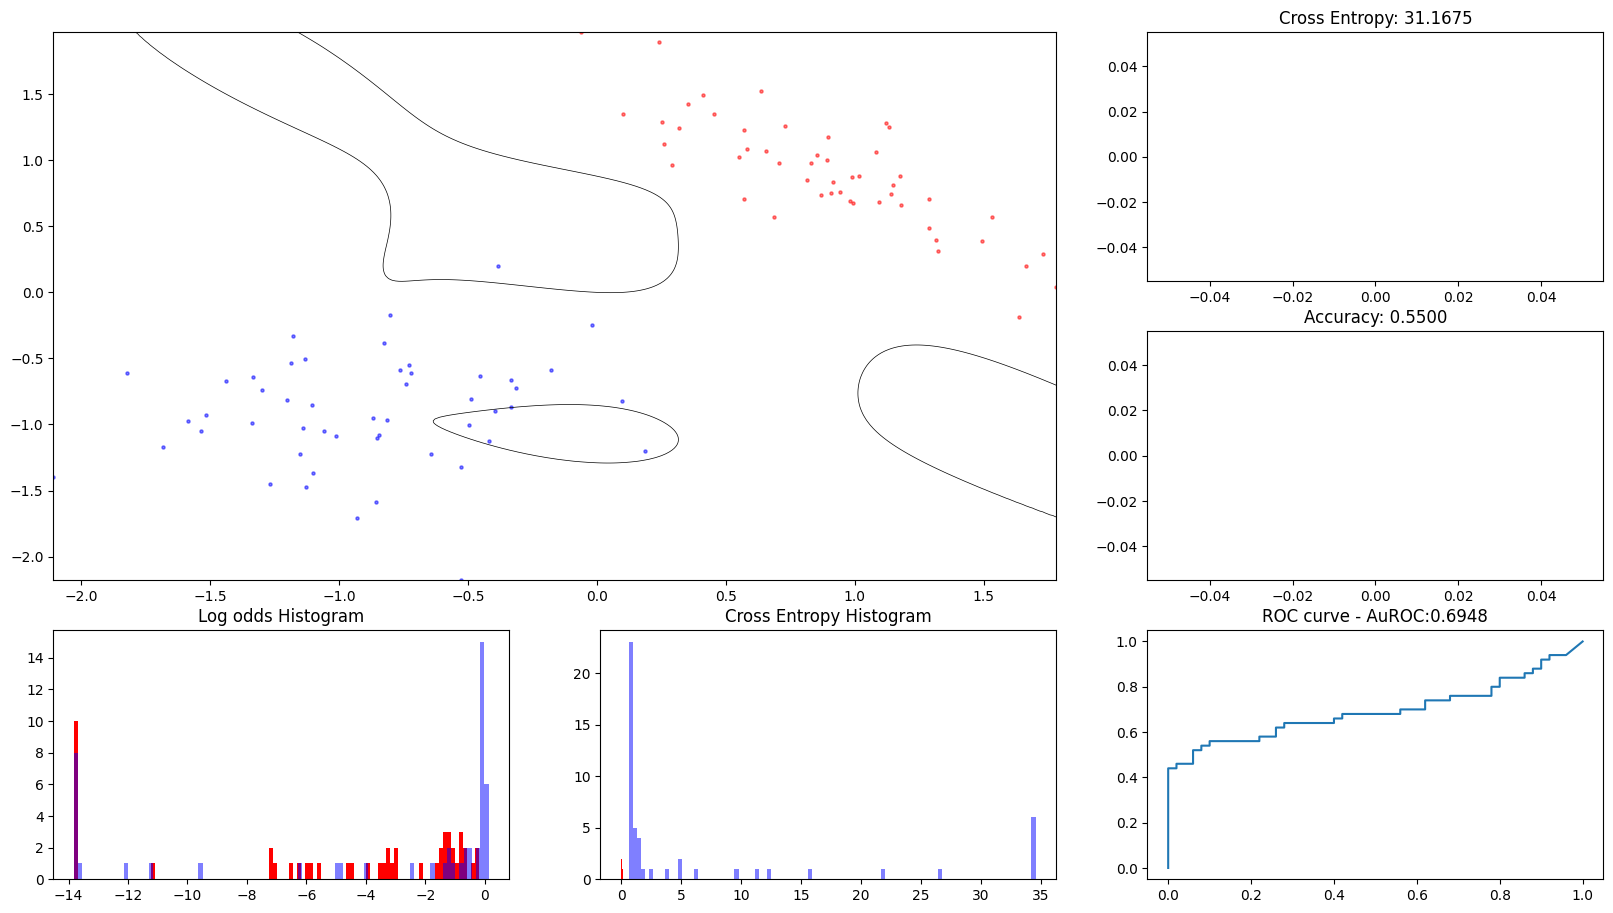

In [106]:
lr = 0.1
model = get_model(lr, load_initial_weight=False)
plotCallback_i = PlotCallback(X, y, degree=degree)
plotCallback_i.plotBoundary(model)

# Entrenamos modelo
Notar que con lr=1 da un resultado pero con lr=10 da otro

In [107]:
# %load_ext tensorboard
# %tensorboard --logdir logs/plots
# tensorboard --logdir logs/plots --samples_per_plugin images=200

In [108]:
degree = 10
polyFeat = PolynomialFeatures(degree=degree, interaction_only=False, include_bias=False)
polyFeat.fit_transform(X)
def feat_eng_transform(data):
    return polyFeat.transform(data)

In [109]:
logdir = "logs/plots/" + datetime.now().strftime("%Y%m%d-%H%M%S")
print(logdir)

logs/plots/20240718-200828


In [110]:
degree

10

In [111]:
lr = 0.1
model = get_model(lr, load_initial_weight=False)
K.set_value(model.optimizer.lr, lr)
plotCallback = PlotCallback(X, y, degree=degree,)
batch_size = 100

/Users/julian/opt/anaconda3/envs/RL/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [112]:
# model.summary()

/Users/julian/opt/anaconda3/envs/RL/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


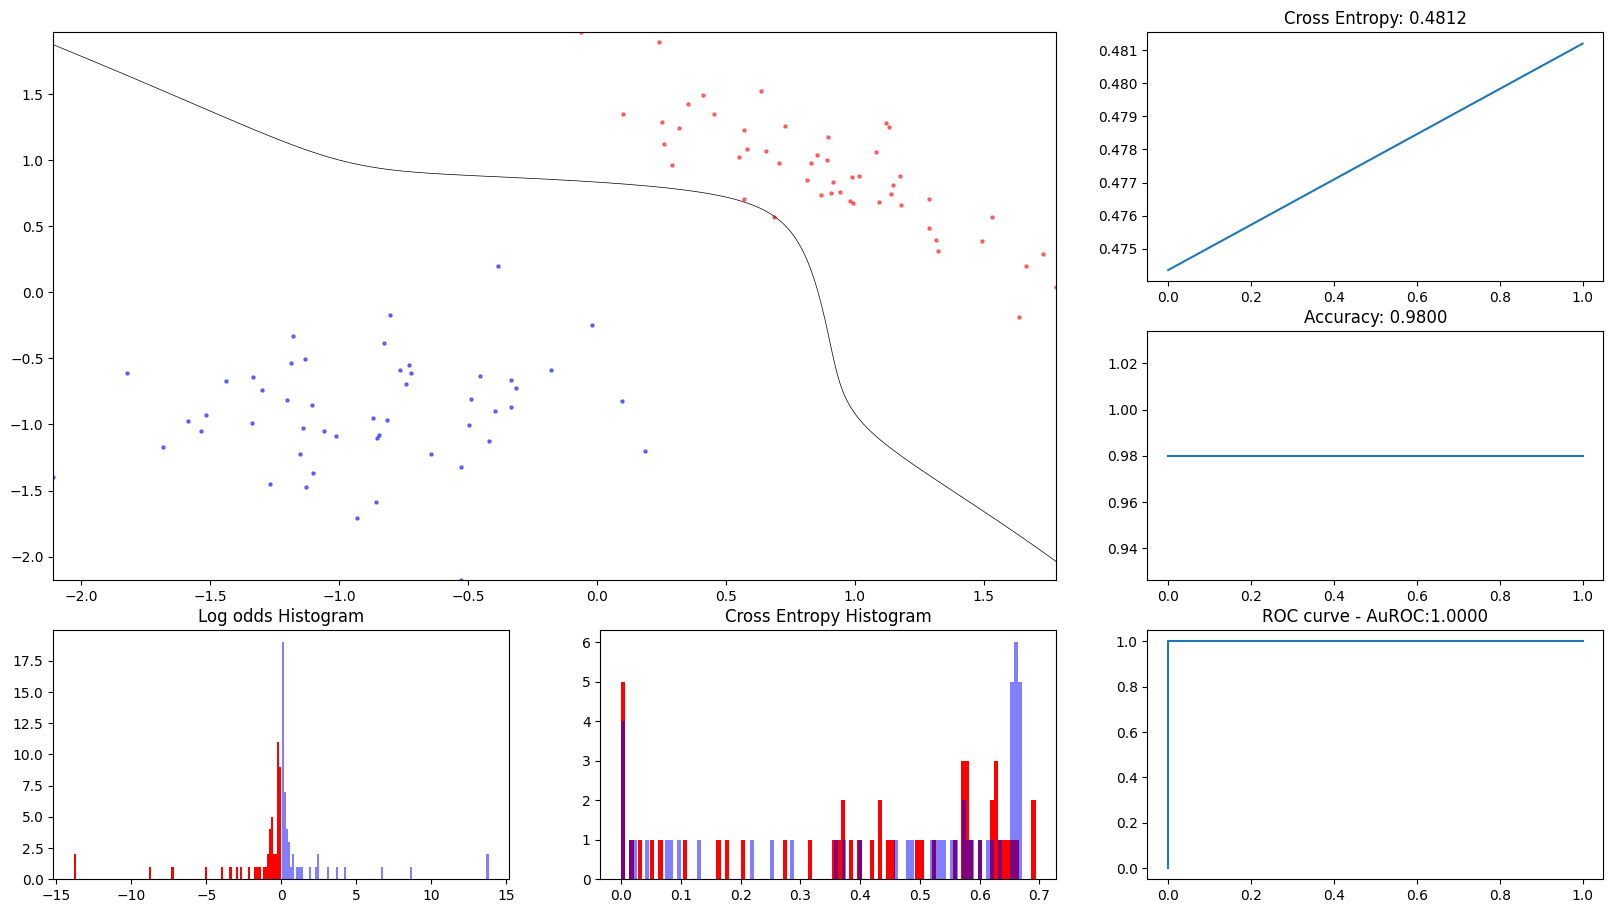

In [114]:
# tbMLPCallback = PlotCallbackTB(X, y, bins=30, N=100, feat_eng_transform=feat_eng_transform, logdir=logdir)
model.fit(X_poly, y, epochs=2000, verbose=0, batch_size=batch_size)
model.fit(X_poly, y, epochs=1, verbose=1, callbacks=[plotCallback], batch_size=batch_size)

In [41]:
model.predict_proba(X_poly).shape

(100, 1)

In [20]:
np.ones(t.shape)

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

# Generamos datos con las distribuciones originales y vemos el accuracy
Equivalente a un accuracy de test

In [54]:
import io

In [55]:
# model.save_weights('final_weights_poly_4.hdf5')
# model.load_weights('final_weights_poly_4.hdf5')

In [45]:
X_f, y_f = generate_gaussians_distributions(sep=1,N = 5000, random_state=10)

Instructions for updating:
Please use `model.predict()` instead.


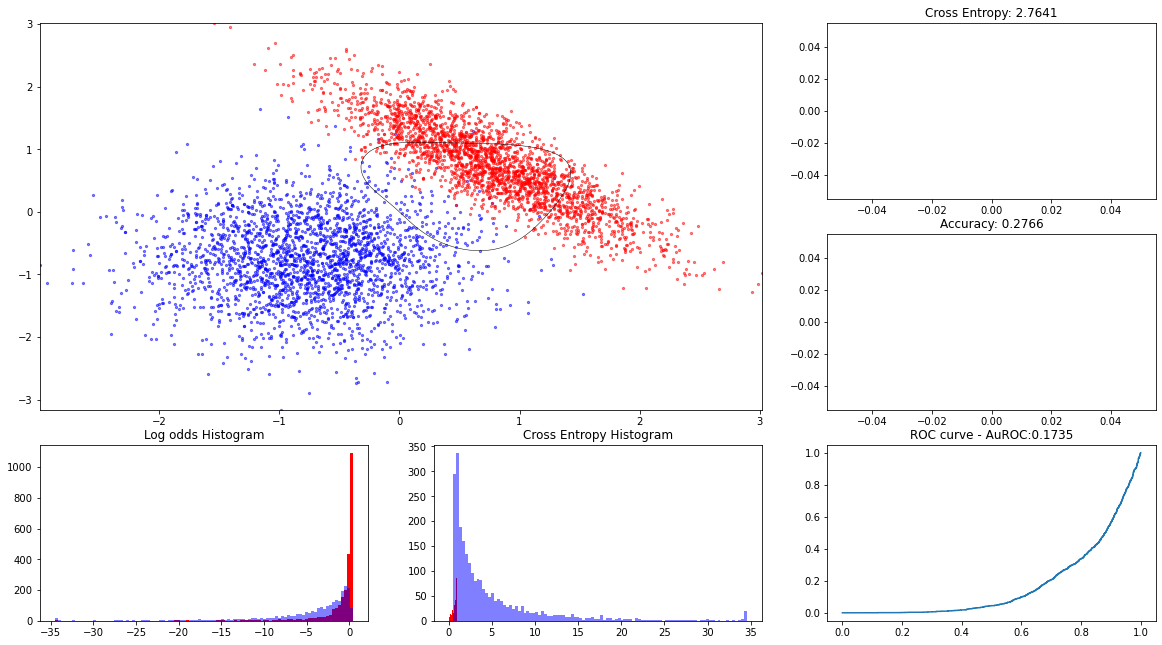

In [46]:
plotCallback_f = PlotCallback(X_f, y_f, degree=degree)
plotCallback_f.plotBoundary(model)

In [20]:
cm = plt.cm.RdBu

In [33]:
cmap = plt.cm.get_cmap('RdBu')
def get_colors_from_p(ps):
    return np.array([list(cmap(p)[:3]) + [0.5] for p in ps])*255

get_colors_from_p(np.array([0.1, 0.2, 0.8]))

array([[176.52941176,  23.52941176,  42.76470588, 127.5       ],
       [214.        ,  96.        ,  77.        , 127.5       ],
       [ 67.        , 147.        , 195.        , 127.5       ]])

In [29]:
list(cmap(0.1)[:3]) + [0.5]

[0.6922722029988466, 0.09227220299884659, 0.1677047289504037, 0.5]

In [42]:
rgba

(0.403921568627451, 0.0, 0.12156862745098039, 1.0)

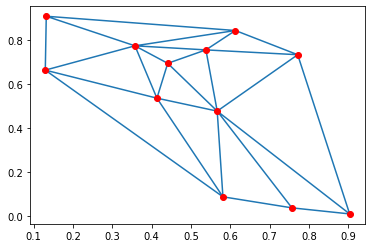

In [16]:
import numpy as np
from  scipy.spatial import Delaunay
import pylab

data = np.random.random((12,3))            # arbitrary 3D data set
tri = Delaunay( data[:,:2] ) # take the first two dimensions

pylab.triplot( data[:,0], data[:,1], tri.simplices.copy() )
pylab.plot( data[:,0], data[:,1], 'ro' ) ;


In [29]:
data 

array([[0.41330466, 0.53546872, 0.34264313],
       [0.12957678, 0.66282175, 0.93567   ],
       [0.61272918, 0.8427385 , 0.21790844],
       [0.90317174, 0.00976998, 0.22581273],
       [0.13205513, 0.90754295, 0.91023064],
       [0.58105791, 0.08749305, 0.11687944],
       [0.77107126, 0.73279527, 0.08712836],
       [0.3574632 , 0.77321162, 0.1314716 ],
       [0.53783243, 0.75472357, 0.27252618],
       [0.566517  , 0.47668497, 0.55662069],
       [0.44073706, 0.69373736, 0.71823718],
       [0.75638236, 0.03732201, 0.6788354 ]])

In [31]:
tri.simplices.copy()

array([[ 6, 10,  2],
       [10,  6,  0],
       [ 6,  8,  0],
       [ 8,  7,  0],
       [ 7,  8,  3],
       [ 9,  4,  2],
       [ 7, 11,  0],
       [11,  4,  9],
       [ 4, 11,  5],
       [ 5, 11,  3],
       [11,  7,  3],
       [ 1, 10,  0],
       [11,  1,  0],
       [ 1, 11,  9],
       [ 1,  9,  2],
       [10,  1,  2]], dtype=int32)